In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import PIL.Image as Image
import shutil

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

device = 'cuda:0'

분석 대상 이미지들의 개수:  1446


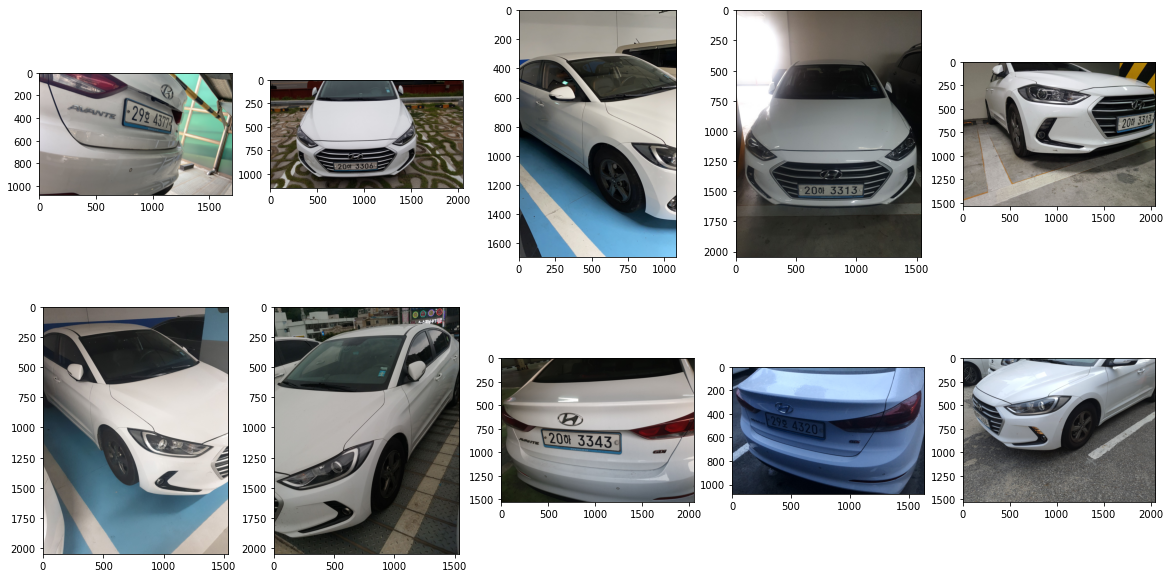

In [3]:
img_path = os.getenv('HOME')+'/aiffel/socar_clustering/data/images/avante_images'
print('분석 대상 이미지들의 개수: ', len(os.listdir(img_path)))

fig = plt.figure(figsize=(20, 10))
columns = 5
rows = 2
for i in range(1, columns*rows +1):  # 샘플 10개 이미지만 골라서

    filename = os.listdir(img_path)[i]
    filepath = os.path.join(img_path, filename) # 파일 이름으로 읽고
    img = cv2.imread(filepath)[:,:,::-1] # 이미지로 읽은 후에 -> RGB 채널을 순서를 변경해주고

    fig.add_subplot(rows, columns, i)
    plt.imshow(img)# 이미지를 plotting 합니다
plt.show()

In [4]:
sample_path = os.getenv('HOME')+'/aiffel/socar_clustering/data/images/avante_images/0.jpg' # path를 정의하고
sample_img = cv2.imread(sample_path) #  OpenCV-python을 이용해서 이미지를 읽기

print(type(sample_img)) # NumPy.array 타입
print(sample_img.shape) # height 1633 x width 1080 x channel 3 짜리 이미지가 나왔습니다

<class 'numpy.ndarray'>
(1633, 1080, 3)


### 이미지 resizing
* OpenCV-python으로 이미지 읽기
* 이미지 NumPy array 형태에서 channel 파악하기
* BGR 채널 → RGB 채널로 바꾸어주기

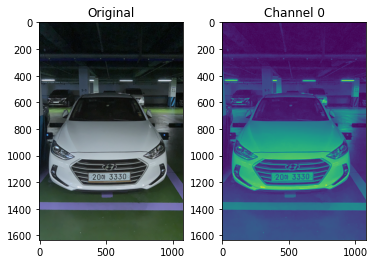

In [10]:
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(sample_img)

plt.subplot(1,2,2)
plt.title('Channel 0')
channel_img = sample_img[:,:,0] # 0번째 채널 이미지
plt.imshow(channel_img)

*  OpenCV-python으로 이미지를 읽으면 채널이 RGB가 아닌 BGR로 읽힘
* 이 이미지를 다시 RGB 채널로 뒤집어주어야 함

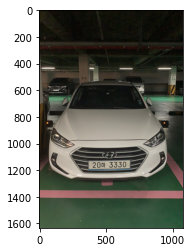

In [11]:
sample_img_rgb = sample_img[:,:,::-1]
plt.imshow(sample_img_rgb)

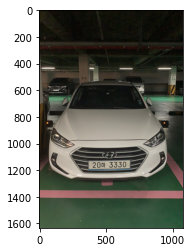

In [13]:
from PIL import Image

img = Image.fromarray(np.uint8(sample_img_rgb))
plt.imshow(img)

* 각각의 Resizing 방법, 즉 CenterCrop, Linear Interpolation, RandomCrop을 사용하면 샘플 이미지가 어떻게 달라지는지 알아보기

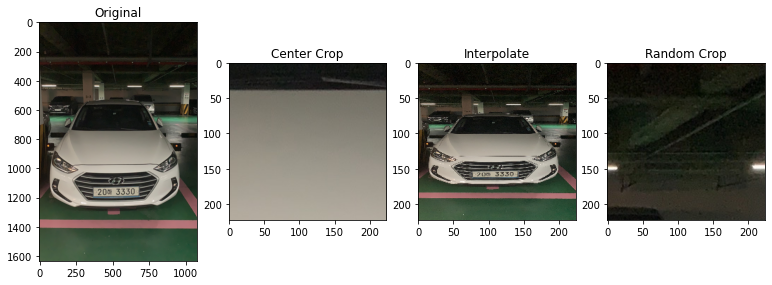

In [15]:
from torchvision import datasets, transforms

center_cropper = transforms.Compose([
    transforms.CenterCrop((224,224)),
])

interpolater = transforms.Compose([
    transforms.Resize((224,224), interpolation=Image.NEAREST)
])

random_cropper = transforms.Compose([
    transforms.RandomCrop((224,224))
])

center_crop = center_cropper(img)
interpolate = interpolater(img)
random_crop = random_cropper(img)

plt.figure(figsize=(13,5))
plt.subplot(1,4,1)
plt.title('Original')
plt.imshow(img)

plt.subplot(1,4,2)
plt.title('Center Crop')
plt.imshow(center_crop)

plt.subplot(1,4,3)
plt.title('Interpolate')
plt.imshow(interpolate)

plt.subplot(1,4,4)
plt.title('Random Crop')
plt.imshow(random_crop)

### 이미지를 벡터로 바꿔주기(Representation Vector)
* 이미지 클러스터링을 위해서는 고차원 이미지 데이터를 저차원으로 매핑해야 함
* 이후 CNN 아키텍처(Architecture)를 이용하여 Representation Vector를 뽑는 과정을 거침

#### Representation Vector
* 이미지 자체는 고차원 데이터(high-dimensional)이기 때문에, 클러스터링 알고리즘을 바로 적용하면 차원의 저주에 빠짐
* PCA와 같은 알고리즘을 이용할 수도 있겠지만, 이미지의 특징을 제대로 담고 있지 못할 가능성이 큼
* AlexNet, VGG, ResNet와 같은 딥러닝 모델들은 이미지 인식에 뛰어난 성능을 보이는 모델
* 해당 모델의 구조를 이용하면 이미지 정보를 잘 담고 있는 벡터를 추출 할 수 있음
* 이를 Representation Vector 라고 함, "표현 벡터"라고 번역할 수 있음
* CNN 아키텍처를 이용하여 Representation Vector를 뽑는다.

#### 클러스터링 일반적인 절차
1. feature selection - 주어진 데이터에서 어떤 변수를 이용해서 벡터화를 할것인가
2. 클러스터링 알고리즘 선택
3. 결과물을 검증
4. 해석 단계
3. 에서 클러스터링은 비지도 학습이기 때문에 공인된 평가척도는 없으나, 하나의 군집내 분산은 최소화하여야 하고 군집간 분산은 최대화 해야 한다는 군집의 타당성 지표 들이 있음

elbow point 로 군집의 갯수를 최적으로 정하기도 함.(타당성)

#### 군집의 타당성 지표를 평가하는 방법

- 상황에 따라서 여러가지 가능성이 존재하기 때문에 세계적으로 인정된 평가 지표가 없음
- 군집화는 비지도 학습이기 때문에 정확한 답을 알수 없음. (라벨이 없음)
- 타당성을 따지기 위한 크게 3가지 접근법이 존재
- External(외부적): 알려진 답과 군집 구조를 비교합니다. (비현실적)
  ㄴ새로운 알고리즘을 개발할때 이 알고리즘이 얼마나 잘하냐 평가하기 위해 (연구용, 논문용)
- Internal(내부적): 군집의 조밀성에 중점을 둡니다.
- Relative(상대적): 군집의 조밀성과 군집 간의 분리에 중점을 둡니다.
 ㄴ 주로 사용되는 방법

두 군집간의 거리를 계산할때는 다른 군집간의 객체들의 거리를 계산한 후 그 중 최소값을 사용

군집의 지름을 계산할때는 하나의 군집내의 속하는 객체들 중 두개씩 뽑아 그 거리를 계산한 후 그 중 최대값을 사용

좋은 군집이라 함은 두 군집간의 거리가 클수록 좋고, 군집의 지름의 최대값이 작을수록 좋다.
 ㄴ 군집간의 거리가 멀어야 확실히 구분이 가고, 군집의 지름이 작아야 군집이 잘 모여있음

#### Dunn Index의 공식
- 군집간 거리들 중 최솟값(분자) 분의 군집의 지름들 중 최댓값(분모)


#### Silhouette(실루엣)지표
- 각각의 개체별로 계산
- a(i) : i라는 객체로 부터 같은 군집간에 속하는 객체들의 거리의 평균(값이 적을수록 좋음)
- b(i) : i라는 객체로 부터 다른 군집에 속하는 군집간의 객체들의 거리 평균 값중 최소값
- s(i)는 b(i) - a(i)를 분자 a(i)와 b(i)중 큰 값을 분모로 넣어 계산
- 기본적으로 s(i)의 가장 큰값은 1 (a(i)가 0이 될수 있기때문) 최소값은 -1(b(i)가 0이 될수 있기 때문)
- 위의 과정을 데이터내의 모든 객체에다가 반복한 후 전체값의 평균이 데이터셋의 실루엣 값
- 결과적으로 실루엣 값이 높을수록 좋다
<img src="https://i.ibb.co/ngWYtGS/Silhouette.png">


#### 클러스터링 타입
- overlap을 허용하느냐 안하느냐에 따라서 Hard Clustering, Soft Clustering 으로 나누어짐
- Hard Clustering은 하나의 객체가 두개이상의 군집에 속하는 것을 허용하지 않음.
- 반면에 Soft Clustering은 하나의 객체가 두개이상의 군집에 속하는 것을 허용함.
- 위의 경우는 군집화를 진행하며 애매한 포인트의 경우(두 군집의 중간 포인트)에 말하는 것


#### Hard Clustering의 알고리즘 중 4가지
- 데이터를 한꺼번에 동시 다발적으로 구분하는 것을 partitional Clustering(분리형 군집화){파티셔널}
- 부분적으로 군집화를 계속해서 bottom-up 혹은 top-down형식으로 가는것이 Hierarchical clustering(계층형 군집화){하이라키컬}

##### K-Means Clustering
- 데이터를 K개의 군집으로 나누는 알고리즘
- 먼저 초기 중심점을 무작위로 선택하고, 각 데이터 포인트를 가장 가까운 중심점의 군집에 할당
- 그런 다음 각 군집의 중심점을 해당 군집에 속하는 데이터 포인트의 평균으로 업데이트
- 이 과정을 반복하여 중심점이 수렴하고 군집이 형성

##### Hierarchical Clustering(계층형 군집화)
- 데이터를 트리 구조로 나타내는 알고리즘
- 처음에 각 데이터 포인트가 개별 군집으로 시작
- 그 후, 더 유사한 군집을 병합하여 계층적인 군집 구조를 생성
- 사용자는 원하는 수준에서 군집을 선택할 수 있음

##### Density clustering(밀도형 군집화)DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
- 데이터의 밀도를 기반으로 군집을 형성하는 클러스터링 알고리즘
- 데이터 포인트가 다른 포인트들로부터 얼마나 가까이 몰려 있는지를 고려하여 군집을 생성
- 불규칙한 모양과 크기를 가진 군집을 찾는 데 효과적
- 핵심 포인트라고 불리는 중심 데이터 포인트를 정의
- 핵심 포인트는 주변에 최소 개수의 이웃 데이터 포인트 (minPts)가 있을 때, 특정 반경 (eps) 내에 위치한 데이터 포인트
- 경계 포인트는 핵심 포인트의 반경 내에 위치하지만, minPts 조건을 만족하지 못하는 데이터 포인트
- 잡음 포인트는 핵심 포인트와 경계 포인트가 아니며, 어떤 군집에도 속하지 않는 데이터 포인트
- 알고리즘 동작 단계:
1.시작점 선택: 임의의 데이터 포인트를 선택하여 시작점으로 설정합니다.
2.밀도 기반 확장: 시작점에서 minPts 개수의 이웃을 찾습니다. 이들 이웃이 한 데이터 포인트의 밀도 내에 있으면 이들을 하나의 군집으로 묶습니다.
3.밀도 연결: 새로운 핵심 포인트를 찾을 때까지 밀도가 증가하는 방향으로 데이터 포인트를 연결하고 군집을 확장합니다.
4.경계 포인트 할당: 군집의 경계 포인트를 할당하여 군집을 완성합니다.
5.잡음 포인트 식별: 잡음 포인트를 식별하고 군집에서 제외합니다.

##### Partitional Clustering(분리형 군집화)
- 데이터를 서로 겹치지 않는 부분 집합인 클러스터로 나누는 비계층적인 방법
- 데이터를 미리 지정한 수의 클러스터로 분할하며, 각 데이터 포인트는 정확히 하나의 클러스터에 속함
- 파티션 클러스터링은 사용자가 원하는 클러스터의 개수(K)를 미리 정해야 함.
- 클러스터 간의 계층 구조를 생성하지 않으며, 모든 클러스터가 동등한 수준(하위 클러스터를 더 작은 클러스터로 분할하지 않음)
- 각 데이터 포인트는 정확히 하나의 클러스터에 속함
- 데이터 포인트 사이의 거리나 유사성을 기반으로 클러스터를 형성